Import necessary libraries


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import math

Define the neural network architecture

In [23]:
class CustomNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.h1 = nn.Linear(28 * 28, 128)  # Assuming MNIST images are 28x28 pixels
        self.ln1 = nn.LayerNorm(128)
        self.act1 = nn.ReLU()
        self.d1 = nn.Dropout(0.2)
        self.h2 = nn.Linear(128, 64)
        self.ln2 = nn.LayerNorm(64)
        self.act2 = nn.ReLU()
        self.d2 = nn.Dropout(0.2)
        self.output = nn.Linear(64, 10)  # Output size should match the number of classes (digits)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input (assuming MNIST images are 28x28 pixels)
        x = self.ln1(self.act1(self.h1(x)))
        x = self.d1(x)
        x = self.act2(self.h2(x))
        x = self.ln2(x)
        x = self.d2(x)
        x = self.output(x)
        return nn.functional.softmax(x,dim=1)

Data preprocessing and loading

In [24]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Split data into training and validation sets
training_data, validation_data, training_labels, validation_labels = train_test_split(
    mnist_data.data, mnist_data.targets, stratify=mnist_data.targets, test_size=0.2, random_state=42
)
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CustomNN()

# Helps improve convergence
training_dataset = torch.utils.data.TensorDataset(training_data.float() / 255.0, training_labels)
validation_dataset = torch.utils.data.TensorDataset(validation_data.float() / 255.0, validation_labels)


Training function

In [25]:
def training_loop(learning_rate, batch_size):
    model = CustomNN()

    loss_function = nn.CrossEntropyLoss()
    optimizing_function = optim.SGD(model.parameters(), lr=learning_rate)

    # Adjust batch size
    training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=batch_size, shuffle=True)
    validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=False)

    epochs_number = 10
    training_losses, validation_losses, training_accuracies, validation_accuracies = [], [], [], []
    best_validation_loss = math.inf
    best_model = None

    for epoch in range(epochs_number):
        model.train()
        for inputs, labels in training_loader:
            optimizing_function.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizing_function.step()

        model.eval()
        with torch.no_grad():
            training_loss = sum(loss_function(model(inputs), labels) for inputs, labels in training_loader)
            training_accuracy = sum((model(inputs).argmax(dim=1) == labels).float().mean().item() for inputs, labels in training_loader)
            validation_loss = sum(loss_function(model(inputs), labels) for inputs, labels in validation_loader)
            validation_accuracy = sum((model(inputs).argmax(dim=1) == labels).float().mean().item() for inputs, labels in validation_loader)

        validation_loss /= len(validation_loader)
        validation_accuracy /= len(validation_loader)
        training_loss /= len(training_loader)
        training_accuracy /= len(training_loader)

        if validation_loss < best_validation_loss:
            best_model = model
            best_validation_loss = validation_loss

        training_losses.append(training_loss.item())
        validation_losses.append(validation_loss.item())
        training_accuracies.append(training_accuracy)
        validation_accuracies.append(validation_accuracy)

        print(f'Epoch number: {epoch + 1}/{epochs_number}, '
              f'Training Loss is: {training_loss:.4f}, Training Accuracy is: {training_accuracy:.4f}, '
              f'Validation Loss is: {validation_loss:.4f}, Validation Accuracy is: {validation_accuracy:.4f}')

    # Plot the metrics for each combination of learning rate and batch size
    plt.plot(training_losses, label=f'Loss of Training  (LR={learning_rate}, Batch Size={batch_size})')
    plt.plot(validation_losses, label=f'Loss of Validation  (LR={learning_rate}, Batch Size={batch_size})')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    plt.plot(training_accuracies, label=f'Training Accuracy (LR={learning_rate}, Batch Size={batch_size})')
    plt.plot(validation_accuracies, label=f'Validation Accuracy (LR={learning_rate}, Batch Size={batch_size})')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

    return best_model, best_validation_loss

Hyperparameter tuning loop


Training with Learning Rate: 0.001, Batch Size: 32
Epoch number: 1/10, Training Loss is: 1.9809, Training Accuracy is: 0.6161, Validation Loss is: 1.9804, Validation Accuracy is: 0.6144
Epoch number: 2/10, Training Loss is: 1.8392, Training Accuracy is: 0.7450, Validation Loss is: 1.8399, Validation Accuracy is: 0.7398
Epoch number: 3/10, Training Loss is: 1.7260, Training Accuracy is: 0.8554, Validation Loss is: 1.7268, Validation Accuracy is: 0.8542
Epoch number: 4/10, Training Loss is: 1.6603, Training Accuracy is: 0.8814, Validation Loss is: 1.6614, Validation Accuracy is: 0.8818
Epoch number: 5/10, Training Loss is: 1.6236, Training Accuracy is: 0.8957, Validation Loss is: 1.6250, Validation Accuracy is: 0.8958
Epoch number: 6/10, Training Loss is: 1.6004, Training Accuracy is: 0.9056, Validation Loss is: 1.6023, Validation Accuracy is: 0.9037
Epoch number: 7/10, Training Loss is: 1.5842, Training Accuracy is: 0.9125, Validation Loss is: 1.5866, Validation Accuracy is: 0.9096
Epo

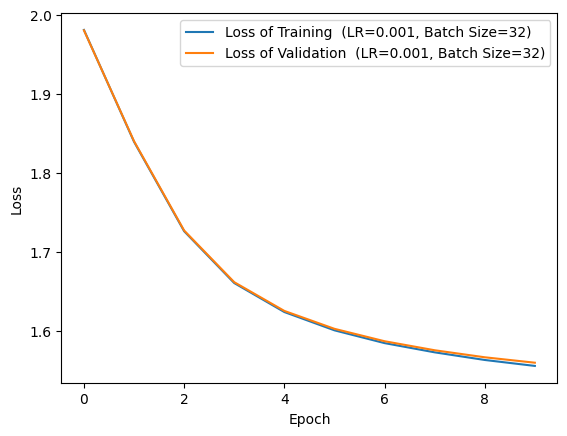

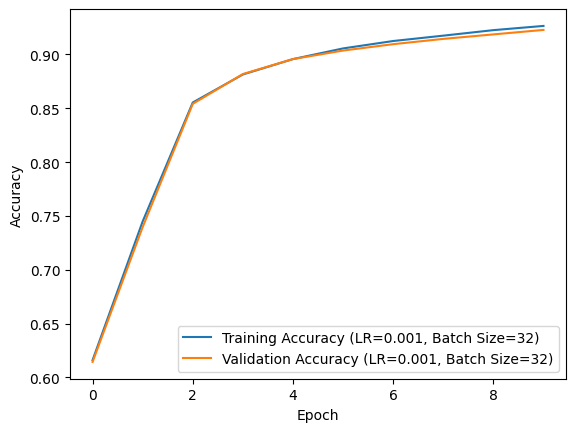


Training with Learning Rate: 0.001, Batch Size: 64
Epoch number: 1/10, Training Loss is: 2.1142, Training Accuracy is: 0.4736, Validation Loss is: 2.1132, Validation Accuracy is: 0.4786
Epoch number: 2/10, Training Loss is: 1.9743, Training Accuracy is: 0.6458, Validation Loss is: 1.9749, Validation Accuracy is: 0.6442
Epoch number: 3/10, Training Loss is: 1.8811, Training Accuracy is: 0.7071, Validation Loss is: 1.8828, Validation Accuracy is: 0.7040
Epoch number: 4/10, Training Loss is: 1.8211, Training Accuracy is: 0.7329, Validation Loss is: 1.8233, Validation Accuracy is: 0.7291
Epoch number: 5/10, Training Loss is: 1.7760, Training Accuracy is: 0.7660, Validation Loss is: 1.7785, Validation Accuracy is: 0.7600
Epoch number: 6/10, Training Loss is: 1.7358, Training Accuracy is: 0.8107, Validation Loss is: 1.7387, Validation Accuracy is: 0.8045
Epoch number: 7/10, Training Loss is: 1.6996, Training Accuracy is: 0.8441, Validation Loss is: 1.7027, Validation Accuracy is: 0.8423
Epo

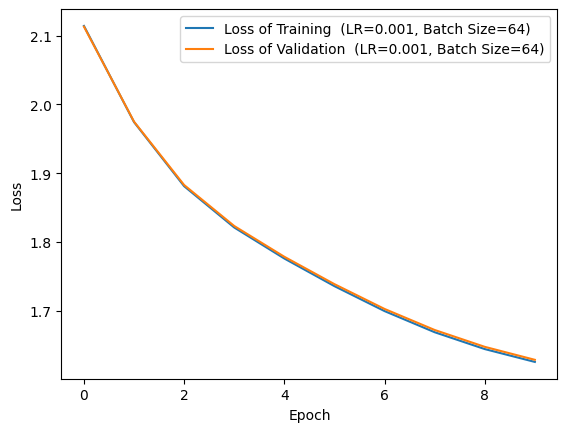

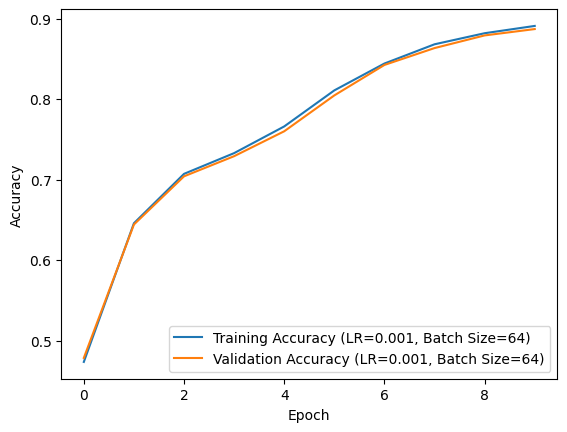


Training with Learning Rate: 0.001, Batch Size: 128
Epoch number: 1/10, Training Loss is: 2.2276, Training Accuracy is: 0.3926, Validation Loss is: 2.2277, Validation Accuracy is: 0.3921
Epoch number: 2/10, Training Loss is: 2.1250, Training Accuracy is: 0.5513, Validation Loss is: 2.1252, Validation Accuracy is: 0.5531
Epoch number: 3/10, Training Loss is: 2.0393, Training Accuracy is: 0.6246, Validation Loss is: 2.0392, Validation Accuracy is: 0.6271
Epoch number: 4/10, Training Loss is: 1.9741, Training Accuracy is: 0.6697, Validation Loss is: 1.9738, Validation Accuracy is: 0.6691
Epoch number: 5/10, Training Loss is: 1.9236, Training Accuracy is: 0.6947, Validation Loss is: 1.9234, Validation Accuracy is: 0.6881
Epoch number: 6/10, Training Loss is: 1.8833, Training Accuracy is: 0.7094, Validation Loss is: 1.8834, Validation Accuracy is: 0.7054
Epoch number: 7/10, Training Loss is: 1.8503, Training Accuracy is: 0.7213, Validation Loss is: 1.8507, Validation Accuracy is: 0.7180
Ep

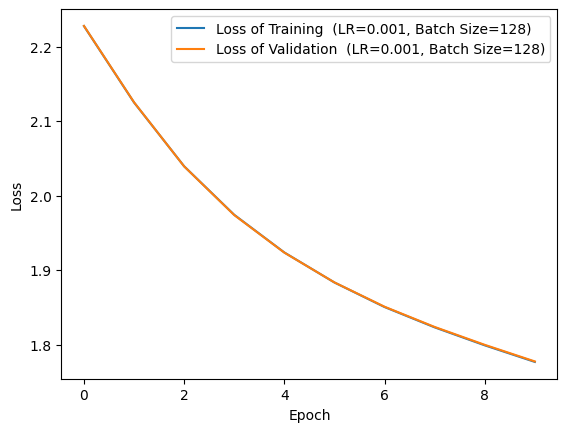

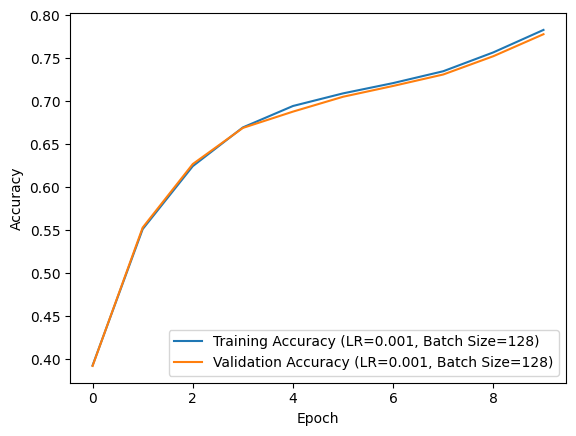


Training with Learning Rate: 0.001, Batch Size: 256
Epoch number: 1/10, Training Loss is: 2.2737, Training Accuracy is: 0.2077, Validation Loss is: 2.2741, Validation Accuracy is: 0.2070
Epoch number: 2/10, Training Loss is: 2.2332, Training Accuracy is: 0.3374, Validation Loss is: 2.2335, Validation Accuracy is: 0.3353
Epoch number: 3/10, Training Loss is: 2.1857, Training Accuracy is: 0.4753, Validation Loss is: 2.1860, Validation Accuracy is: 0.4753
Epoch number: 4/10, Training Loss is: 2.1374, Training Accuracy is: 0.5722, Validation Loss is: 2.1376, Validation Accuracy is: 0.5738
Epoch number: 5/10, Training Loss is: 2.0929, Training Accuracy is: 0.6241, Validation Loss is: 2.0930, Validation Accuracy is: 0.6238
Epoch number: 6/10, Training Loss is: 2.0516, Training Accuracy is: 0.6563, Validation Loss is: 2.0516, Validation Accuracy is: 0.6570
Epoch number: 7/10, Training Loss is: 2.0136, Training Accuracy is: 0.6794, Validation Loss is: 2.0134, Validation Accuracy is: 0.6807
Ep

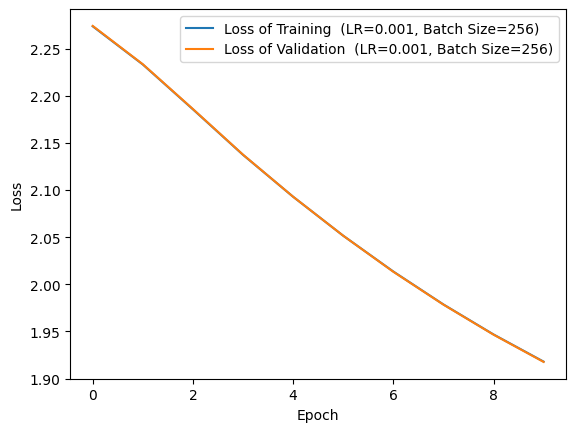

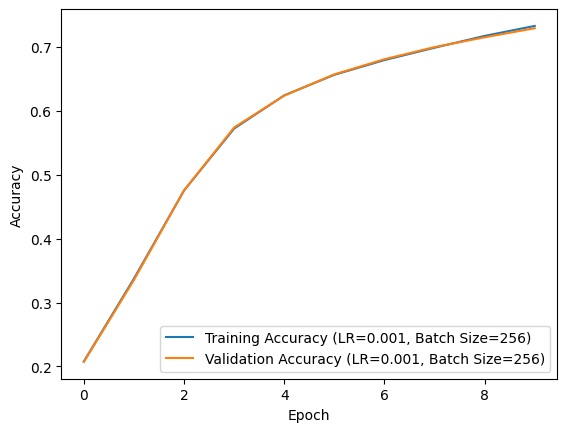


Training with Learning Rate: 0.001, Batch Size: 512
Epoch number: 1/10, Training Loss is: 2.2817, Training Accuracy is: 0.1857, Validation Loss is: 2.2811, Validation Accuracy is: 0.1921
Epoch number: 2/10, Training Loss is: 2.2563, Training Accuracy is: 0.2619, Validation Loss is: 2.2558, Validation Accuracy is: 0.2633
Epoch number: 3/10, Training Loss is: 2.2240, Training Accuracy is: 0.3047, Validation Loss is: 2.2240, Validation Accuracy is: 0.3066
Epoch number: 4/10, Training Loss is: 2.1959, Training Accuracy is: 0.3338, Validation Loss is: 2.1963, Validation Accuracy is: 0.3336
Epoch number: 5/10, Training Loss is: 2.1728, Training Accuracy is: 0.3643, Validation Loss is: 2.1734, Validation Accuracy is: 0.3649
Epoch number: 6/10, Training Loss is: 2.1524, Training Accuracy is: 0.3971, Validation Loss is: 2.1531, Validation Accuracy is: 0.3994
Epoch number: 7/10, Training Loss is: 2.1331, Training Accuracy is: 0.4304, Validation Loss is: 2.1339, Validation Accuracy is: 0.4318
Ep

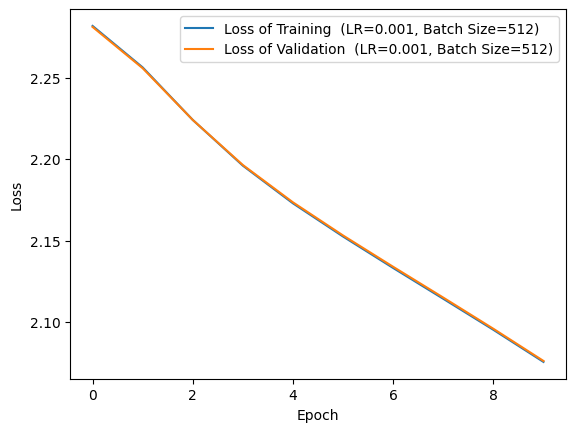

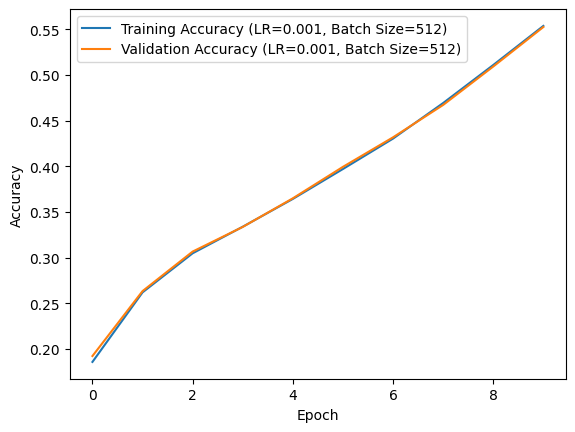


Training with Learning Rate: 0.01, Batch Size: 32
Epoch number: 1/10, Training Loss is: 1.5616, Training Accuracy is: 0.9201, Validation Loss is: 1.5663, Validation Accuracy is: 0.9150
Epoch number: 2/10, Training Loss is: 1.5298, Training Accuracy is: 0.9393, Validation Loss is: 1.5358, Validation Accuracy is: 0.9327
Epoch number: 3/10, Training Loss is: 1.5161, Training Accuracy is: 0.9499, Validation Loss is: 1.5232, Validation Accuracy is: 0.9423
Epoch number: 4/10, Training Loss is: 1.5094, Training Accuracy is: 0.9561, Validation Loss is: 1.5177, Validation Accuracy is: 0.9473
Epoch number: 5/10, Training Loss is: 1.5040, Training Accuracy is: 0.9606, Validation Loss is: 1.5116, Validation Accuracy is: 0.9527
Epoch number: 6/10, Training Loss is: 1.4993, Training Accuracy is: 0.9647, Validation Loss is: 1.5085, Validation Accuracy is: 0.9552
Epoch number: 7/10, Training Loss is: 1.4976, Training Accuracy is: 0.9660, Validation Loss is: 1.5069, Validation Accuracy is: 0.9564
Epoc

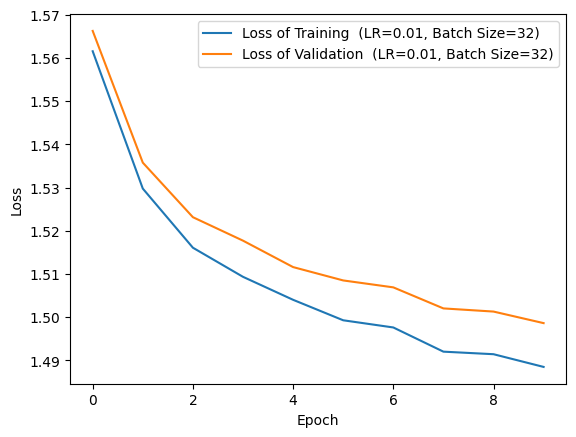

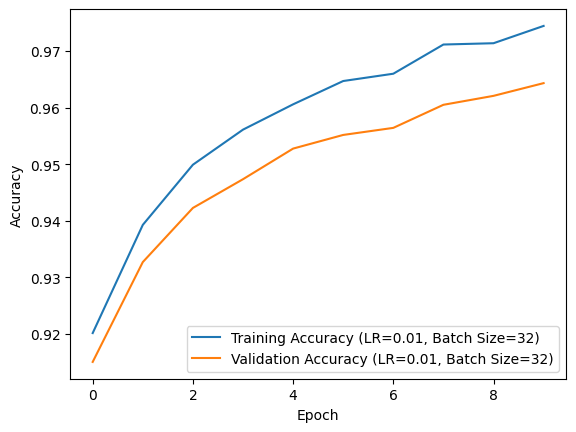


Training with Learning Rate: 0.01, Batch Size: 64
Epoch number: 1/10, Training Loss is: 1.6578, Training Accuracy is: 0.8434, Validation Loss is: 1.6592, Validation Accuracy is: 0.8433
Epoch number: 2/10, Training Loss is: 1.5636, Training Accuracy is: 0.9196, Validation Loss is: 1.5665, Validation Accuracy is: 0.9176
Epoch number: 3/10, Training Loss is: 1.5388, Training Accuracy is: 0.9352, Validation Loss is: 1.5424, Validation Accuracy is: 0.9302
Epoch number: 4/10, Training Loss is: 1.5248, Training Accuracy is: 0.9454, Validation Loss is: 1.5292, Validation Accuracy is: 0.9412
Epoch number: 5/10, Training Loss is: 1.5167, Training Accuracy is: 0.9520, Validation Loss is: 1.5225, Validation Accuracy is: 0.9464
Epoch number: 6/10, Training Loss is: 1.5111, Training Accuracy is: 0.9558, Validation Loss is: 1.5182, Validation Accuracy is: 0.9488
Epoch number: 7/10, Training Loss is: 1.5050, Training Accuracy is: 0.9614, Validation Loss is: 1.5125, Validation Accuracy is: 0.9530
Epoc

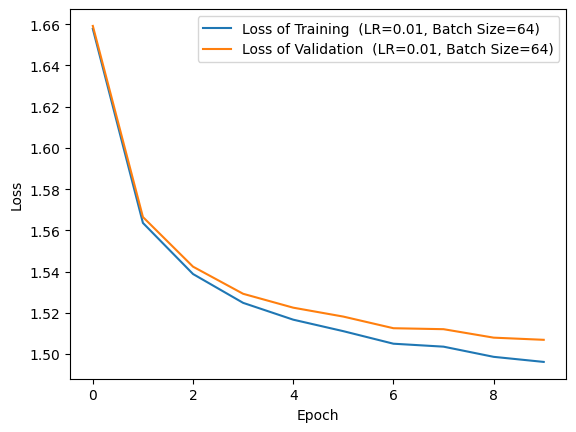

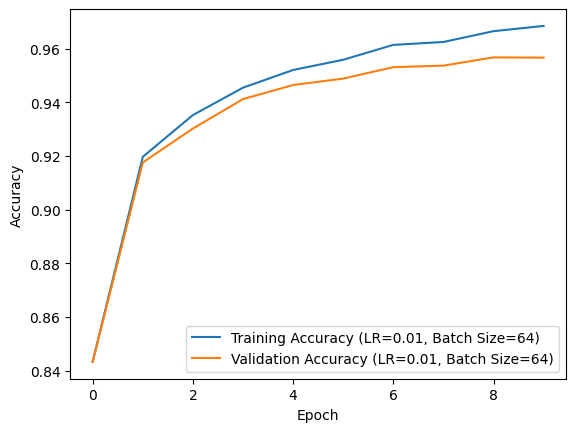


Training with Learning Rate: 0.01, Batch Size: 128
Epoch number: 1/10, Training Loss is: 1.7621, Training Accuracy is: 0.8106, Validation Loss is: 1.7623, Validation Accuracy is: 0.8079
Epoch number: 2/10, Training Loss is: 1.6175, Training Accuracy is: 0.8949, Validation Loss is: 1.6190, Validation Accuracy is: 0.8943
Epoch number: 3/10, Training Loss is: 1.5730, Training Accuracy is: 0.9150, Validation Loss is: 1.5751, Validation Accuracy is: 0.9129
Epoch number: 4/10, Training Loss is: 1.5524, Training Accuracy is: 0.9261, Validation Loss is: 1.5557, Validation Accuracy is: 0.9229
Epoch number: 5/10, Training Loss is: 1.5402, Training Accuracy is: 0.9339, Validation Loss is: 1.5437, Validation Accuracy is: 0.9317
Epoch number: 6/10, Training Loss is: 1.5309, Training Accuracy is: 0.9402, Validation Loss is: 1.5350, Validation Accuracy is: 0.9357
Epoch number: 7/10, Training Loss is: 1.5249, Training Accuracy is: 0.9450, Validation Loss is: 1.5302, Validation Accuracy is: 0.9403
Epo

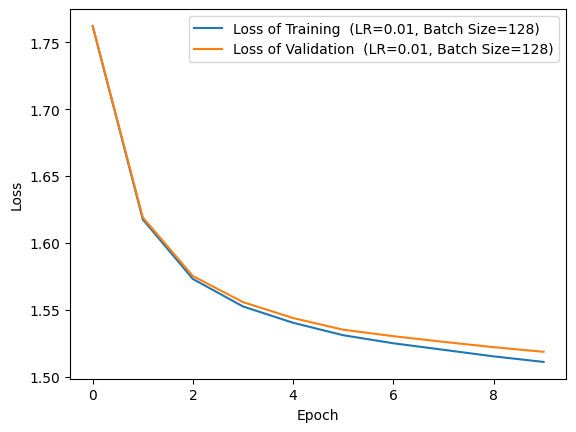

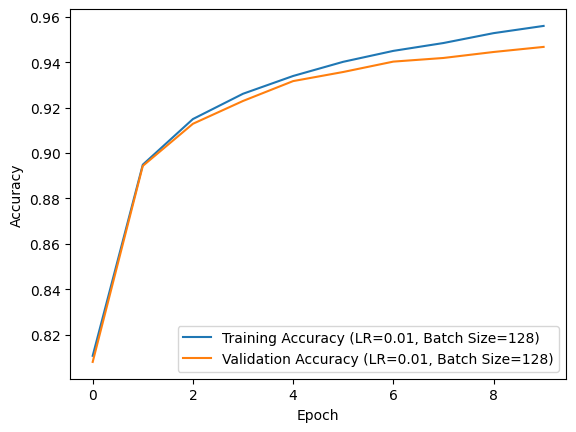


Training with Learning Rate: 0.01, Batch Size: 256
Epoch number: 1/10, Training Loss is: 1.9564, Training Accuracy is: 0.6524, Validation Loss is: 1.9564, Validation Accuracy is: 0.6521
Epoch number: 2/10, Training Loss is: 1.7704, Training Accuracy is: 0.7937, Validation Loss is: 1.7715, Validation Accuracy is: 0.7924
Epoch number: 3/10, Training Loss is: 1.6967, Training Accuracy is: 0.8203, Validation Loss is: 1.6979, Validation Accuracy is: 0.8190
Epoch number: 4/10, Training Loss is: 1.6632, Training Accuracy is: 0.8331, Validation Loss is: 1.6646, Validation Accuracy is: 0.8304
Epoch number: 5/10, Training Loss is: 1.6408, Training Accuracy is: 0.8492, Validation Loss is: 1.6426, Validation Accuracy is: 0.8461
Epoch number: 6/10, Training Loss is: 1.6159, Training Accuracy is: 0.8760, Validation Loss is: 1.6188, Validation Accuracy is: 0.8724
Epoch number: 7/10, Training Loss is: 1.5900, Training Accuracy is: 0.8990, Validation Loss is: 1.5935, Validation Accuracy is: 0.8929
Epo

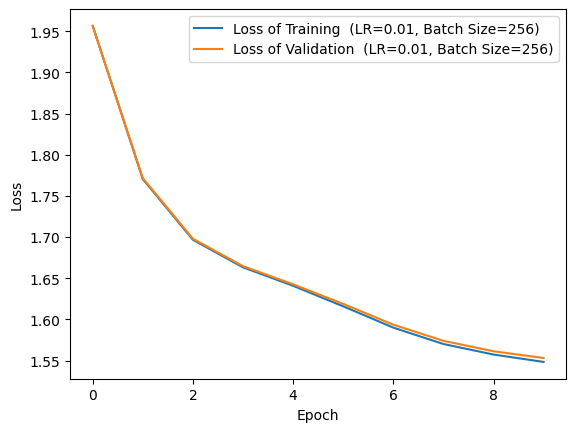

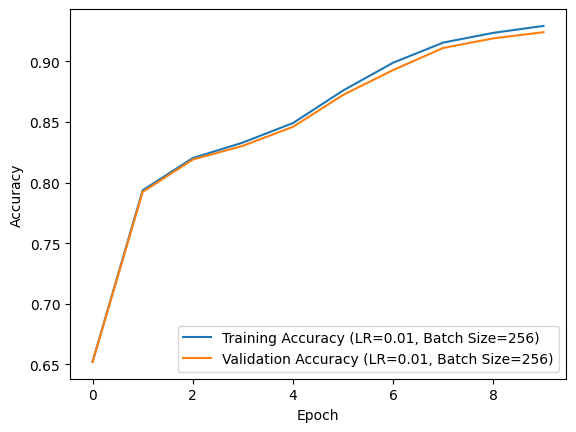


Training with Learning Rate: 0.01, Batch Size: 512
Epoch number: 1/10, Training Loss is: 2.0743, Training Accuracy is: 0.6166, Validation Loss is: 2.0759, Validation Accuracy is: 0.6157
Epoch number: 2/10, Training Loss is: 1.9259, Training Accuracy is: 0.7353, Validation Loss is: 1.9271, Validation Accuracy is: 0.7329
Epoch number: 3/10, Training Loss is: 1.8212, Training Accuracy is: 0.8158, Validation Loss is: 1.8231, Validation Accuracy is: 0.8099
Epoch number: 4/10, Training Loss is: 1.7448, Training Accuracy is: 0.8512, Validation Loss is: 1.7475, Validation Accuracy is: 0.8460
Epoch number: 5/10, Training Loss is: 1.6910, Training Accuracy is: 0.8722, Validation Loss is: 1.6942, Validation Accuracy is: 0.8682
Epoch number: 6/10, Training Loss is: 1.6539, Training Accuracy is: 0.8862, Validation Loss is: 1.6569, Validation Accuracy is: 0.8842
Epoch number: 7/10, Training Loss is: 1.6280, Training Accuracy is: 0.8956, Validation Loss is: 1.6311, Validation Accuracy is: 0.8928
Epo

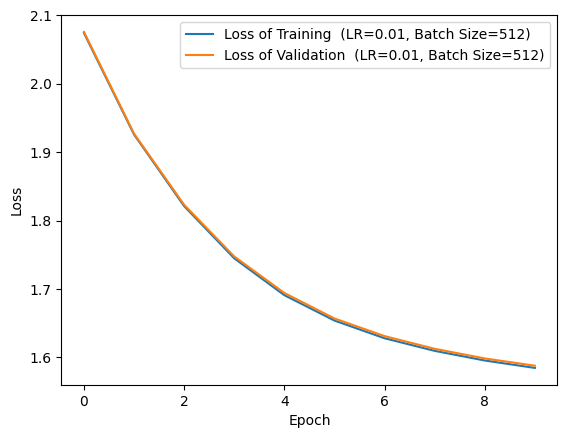

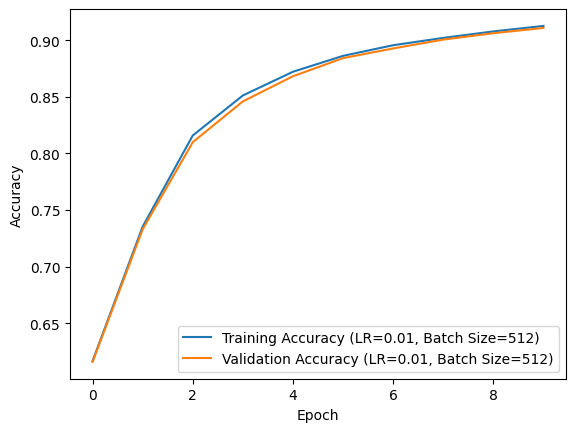


Training with Learning Rate: 0.1, Batch Size: 32
Epoch number: 1/10, Training Loss is: 1.5188, Training Accuracy is: 0.9442, Validation Loss is: 1.5226, Validation Accuracy is: 0.9401
Epoch number: 2/10, Training Loss is: 1.5112, Training Accuracy is: 0.9509, Validation Loss is: 1.5166, Validation Accuracy is: 0.9459
Epoch number: 3/10, Training Loss is: 1.5021, Training Accuracy is: 0.9601, Validation Loss is: 1.5069, Validation Accuracy is: 0.9555
Epoch number: 4/10, Training Loss is: 1.4935, Training Accuracy is: 0.9683, Validation Loss is: 1.4994, Validation Accuracy is: 0.9623
Epoch number: 5/10, Training Loss is: 1.4905, Training Accuracy is: 0.9717, Validation Loss is: 1.4983, Validation Accuracy is: 0.9633
Epoch number: 6/10, Training Loss is: 1.4885, Training Accuracy is: 0.9733, Validation Loss is: 1.4965, Validation Accuracy is: 0.9650
Epoch number: 7/10, Training Loss is: 1.4876, Training Accuracy is: 0.9744, Validation Loss is: 1.4963, Validation Accuracy is: 0.9648
Epoch

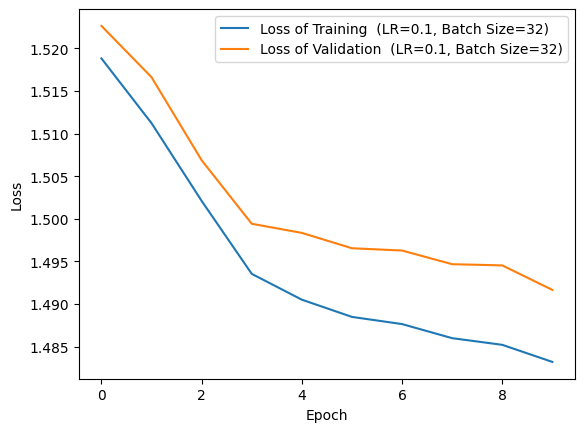

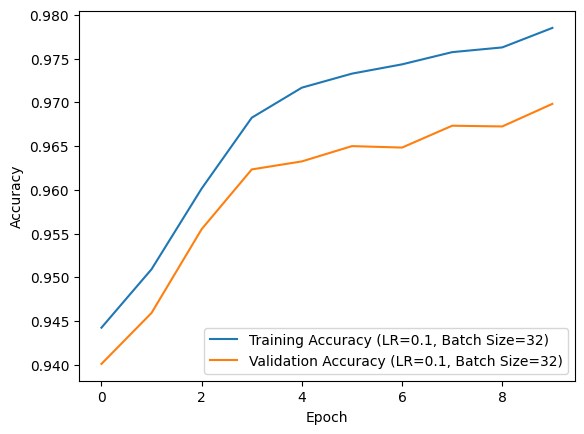


Training with Learning Rate: 0.1, Batch Size: 64
Epoch number: 1/10, Training Loss is: 1.5271, Training Accuracy is: 0.9389, Validation Loss is: 1.5291, Validation Accuracy is: 0.9363
Epoch number: 2/10, Training Loss is: 1.5077, Training Accuracy is: 0.9556, Validation Loss is: 1.5130, Validation Accuracy is: 0.9505
Epoch number: 3/10, Training Loss is: 1.5014, Training Accuracy is: 0.9609, Validation Loss is: 1.5082, Validation Accuracy is: 0.9544
Epoch number: 4/10, Training Loss is: 1.4968, Training Accuracy is: 0.9654, Validation Loss is: 1.5052, Validation Accuracy is: 0.9564
Epoch number: 5/10, Training Loss is: 1.4912, Training Accuracy is: 0.9710, Validation Loss is: 1.4989, Validation Accuracy is: 0.9637
Epoch number: 6/10, Training Loss is: 1.4889, Training Accuracy is: 0.9731, Validation Loss is: 1.4964, Validation Accuracy is: 0.9658
Epoch number: 7/10, Training Loss is: 1.4871, Training Accuracy is: 0.9746, Validation Loss is: 1.4948, Validation Accuracy is: 0.9671
Epoch

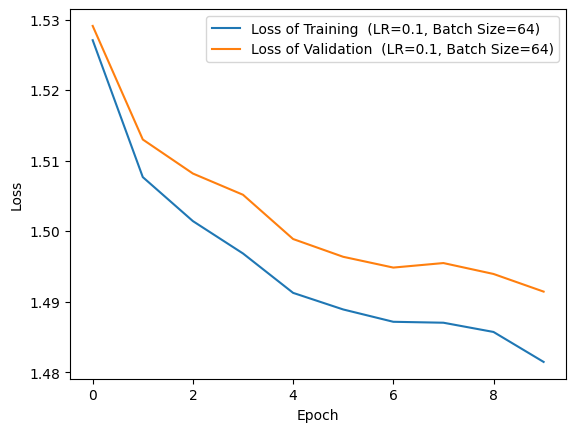

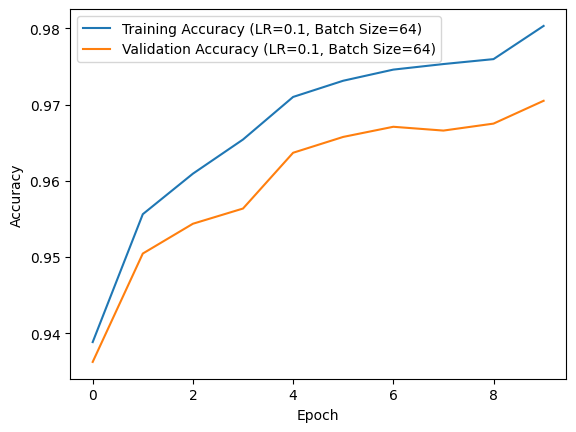


Training with Learning Rate: 0.1, Batch Size: 128
Epoch number: 1/10, Training Loss is: 1.5385, Training Accuracy is: 0.9300, Validation Loss is: 1.5412, Validation Accuracy is: 0.9257
Epoch number: 2/10, Training Loss is: 1.5107, Training Accuracy is: 0.9540, Validation Loss is: 1.5160, Validation Accuracy is: 0.9492
Epoch number: 3/10, Training Loss is: 1.5053, Training Accuracy is: 0.9588, Validation Loss is: 1.5109, Validation Accuracy is: 0.9529
Epoch number: 4/10, Training Loss is: 1.4990, Training Accuracy is: 0.9641, Validation Loss is: 1.5060, Validation Accuracy is: 0.9566
Epoch number: 5/10, Training Loss is: 1.4961, Training Accuracy is: 0.9666, Validation Loss is: 1.5053, Validation Accuracy is: 0.9575
Epoch number: 6/10, Training Loss is: 1.4908, Training Accuracy is: 0.9719, Validation Loss is: 1.4988, Validation Accuracy is: 0.9637
Epoch number: 7/10, Training Loss is: 1.4899, Training Accuracy is: 0.9725, Validation Loss is: 1.4995, Validation Accuracy is: 0.9618
Epoc

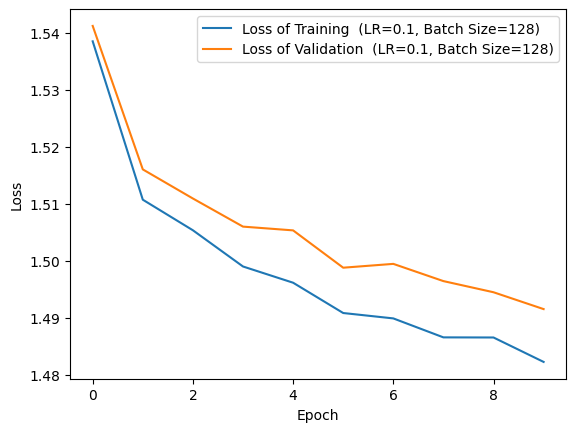

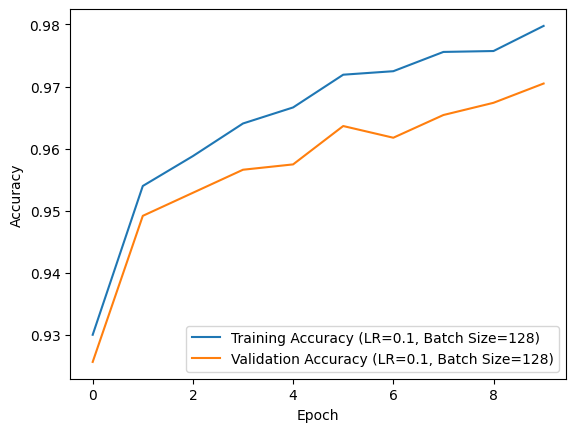


Training with Learning Rate: 0.1, Batch Size: 256
Epoch number: 1/10, Training Loss is: 1.5620, Training Accuracy is: 0.9163, Validation Loss is: 1.5653, Validation Accuracy is: 0.9114
Epoch number: 2/10, Training Loss is: 1.5320, Training Accuracy is: 0.9383, Validation Loss is: 1.5381, Validation Accuracy is: 0.9310
Epoch number: 3/10, Training Loss is: 1.5156, Training Accuracy is: 0.9500, Validation Loss is: 1.5222, Validation Accuracy is: 0.9428
Epoch number: 4/10, Training Loss is: 1.5111, Training Accuracy is: 0.9540, Validation Loss is: 1.5199, Validation Accuracy is: 0.9451
Epoch number: 5/10, Training Loss is: 1.4989, Training Accuracy is: 0.9652, Validation Loss is: 1.5072, Validation Accuracy is: 0.9563
Epoch number: 6/10, Training Loss is: 1.4943, Training Accuracy is: 0.9694, Validation Loss is: 1.5030, Validation Accuracy is: 0.9601
Epoch number: 7/10, Training Loss is: 1.4943, Training Accuracy is: 0.9687, Validation Loss is: 1.5033, Validation Accuracy is: 0.9603
Epoc

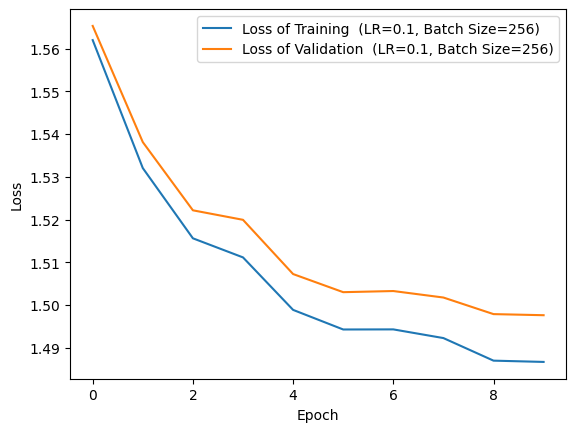

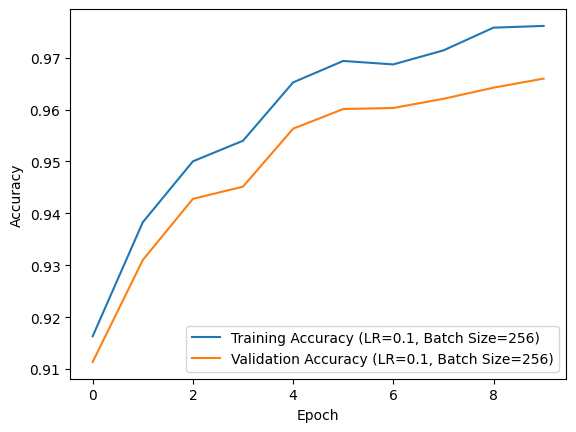


Training with Learning Rate: 0.1, Batch Size: 512
Epoch number: 1/10, Training Loss is: 1.5971, Training Accuracy is: 0.9029, Validation Loss is: 1.5984, Validation Accuracy is: 0.9018
Epoch number: 2/10, Training Loss is: 1.5467, Training Accuracy is: 0.9286, Validation Loss is: 1.5494, Validation Accuracy is: 0.9258
Epoch number: 3/10, Training Loss is: 1.5266, Training Accuracy is: 0.9432, Validation Loss is: 1.5308, Validation Accuracy is: 0.9378
Epoch number: 4/10, Training Loss is: 1.5177, Training Accuracy is: 0.9499, Validation Loss is: 1.5216, Validation Accuracy is: 0.9465
Epoch number: 5/10, Training Loss is: 1.5099, Training Accuracy is: 0.9568, Validation Loss is: 1.5157, Validation Accuracy is: 0.9506
Epoch number: 6/10, Training Loss is: 1.5037, Training Accuracy is: 0.9619, Validation Loss is: 1.5106, Validation Accuracy is: 0.9554
Epoch number: 7/10, Training Loss is: 1.4998, Training Accuracy is: 0.9648, Validation Loss is: 1.5087, Validation Accuracy is: 0.9555
Epoc

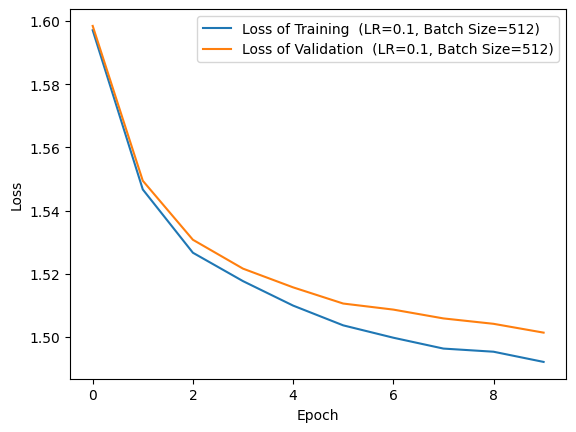

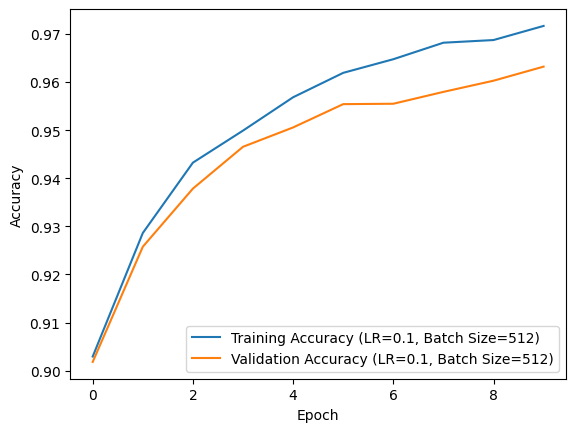


Training with Learning Rate: 0.5, Batch Size: 32
Epoch number: 1/10, Training Loss is: 1.5481, Training Accuracy is: 0.9134, Validation Loss is: 1.5493, Validation Accuracy is: 0.9131
Epoch number: 2/10, Training Loss is: 1.5181, Training Accuracy is: 0.9437, Validation Loss is: 1.5226, Validation Accuracy is: 0.9384
Epoch number: 3/10, Training Loss is: 1.5177, Training Accuracy is: 0.9435, Validation Loss is: 1.5233, Validation Accuracy is: 0.9383
Epoch number: 4/10, Training Loss is: 1.5033, Training Accuracy is: 0.9583, Validation Loss is: 1.5095, Validation Accuracy is: 0.9521
Epoch number: 5/10, Training Loss is: 1.5006, Training Accuracy is: 0.9604, Validation Loss is: 1.5074, Validation Accuracy is: 0.9536
Epoch number: 6/10, Training Loss is: 1.5026, Training Accuracy is: 0.9586, Validation Loss is: 1.5079, Validation Accuracy is: 0.9530
Epoch number: 7/10, Training Loss is: 1.4959, Training Accuracy is: 0.9651, Validation Loss is: 1.5016, Validation Accuracy is: 0.9593
Epoch

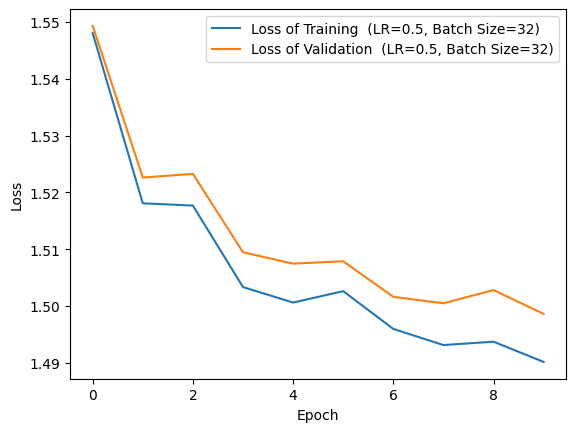

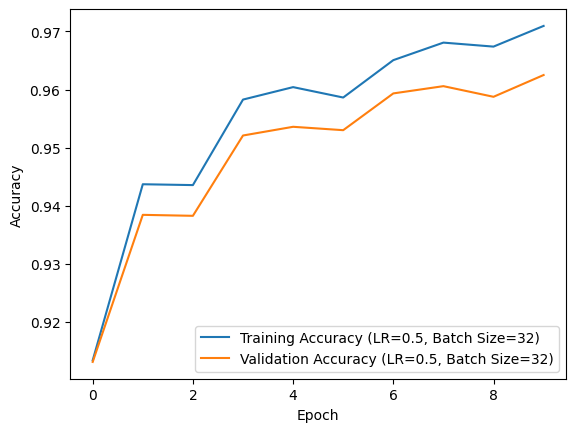


Training with Learning Rate: 0.5, Batch Size: 64
Epoch number: 1/10, Training Loss is: 1.5272, Training Accuracy is: 0.9347, Validation Loss is: 1.5281, Validation Accuracy is: 0.9342
Epoch number: 2/10, Training Loss is: 1.5090, Training Accuracy is: 0.9529, Validation Loss is: 1.5145, Validation Accuracy is: 0.9464
Epoch number: 3/10, Training Loss is: 1.5086, Training Accuracy is: 0.9529, Validation Loss is: 1.5151, Validation Accuracy is: 0.9464
Epoch number: 4/10, Training Loss is: 1.4989, Training Accuracy is: 0.9625, Validation Loss is: 1.5037, Validation Accuracy is: 0.9578
Epoch number: 5/10, Training Loss is: 1.4985, Training Accuracy is: 0.9631, Validation Loss is: 1.5040, Validation Accuracy is: 0.9574
Epoch number: 6/10, Training Loss is: 1.4906, Training Accuracy is: 0.9704, Validation Loss is: 1.4976, Validation Accuracy is: 0.9636
Epoch number: 7/10, Training Loss is: 1.4943, Training Accuracy is: 0.9674, Validation Loss is: 1.5013, Validation Accuracy is: 0.9604
Epoch

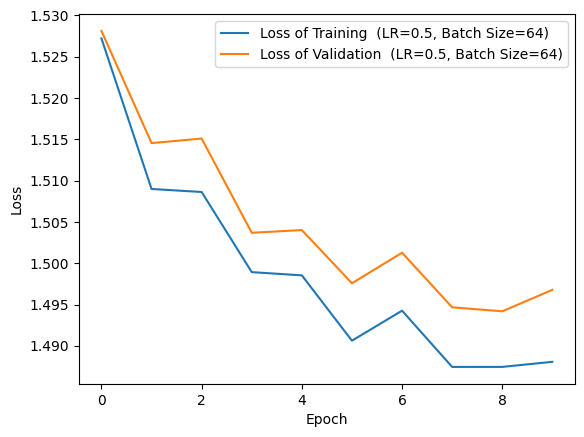

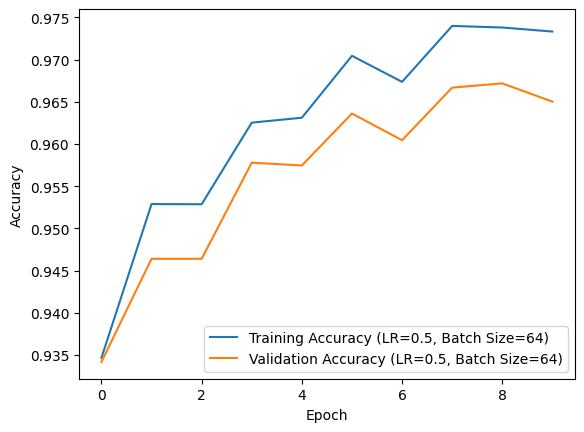


Training with Learning Rate: 0.5, Batch Size: 128
Epoch number: 1/10, Training Loss is: 1.5240, Training Accuracy is: 0.9395, Validation Loss is: 1.5264, Validation Accuracy is: 0.9367
Epoch number: 2/10, Training Loss is: 1.5079, Training Accuracy is: 0.9543, Validation Loss is: 1.5130, Validation Accuracy is: 0.9496
Epoch number: 3/10, Training Loss is: 1.5048, Training Accuracy is: 0.9574, Validation Loss is: 1.5091, Validation Accuracy is: 0.9530
Epoch number: 4/10, Training Loss is: 1.4940, Training Accuracy is: 0.9680, Validation Loss is: 1.5015, Validation Accuracy is: 0.9603
Epoch number: 5/10, Training Loss is: 1.4919, Training Accuracy is: 0.9698, Validation Loss is: 1.4996, Validation Accuracy is: 0.9621
Epoch number: 6/10, Training Loss is: 1.4925, Training Accuracy is: 0.9695, Validation Loss is: 1.5013, Validation Accuracy is: 0.9599
Epoch number: 7/10, Training Loss is: 1.4866, Training Accuracy is: 0.9751, Validation Loss is: 1.4947, Validation Accuracy is: 0.9668
Epoc

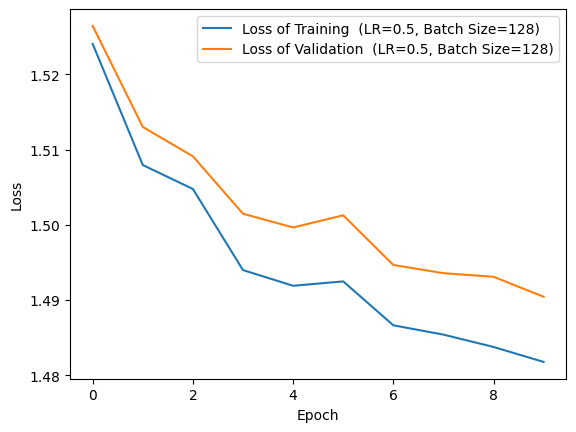

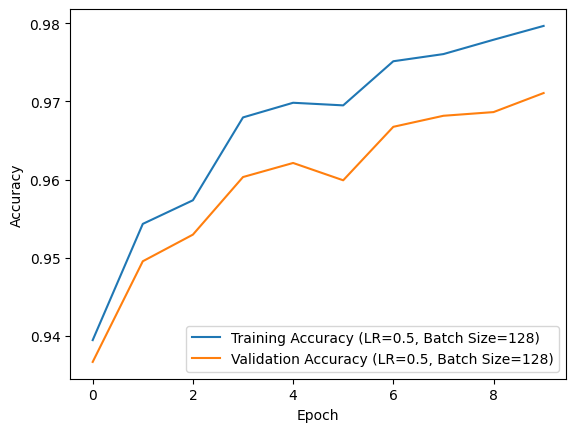


Training with Learning Rate: 0.5, Batch Size: 256
Epoch number: 1/10, Training Loss is: 1.5348, Training Accuracy is: 0.9287, Validation Loss is: 1.5379, Validation Accuracy is: 0.9266
Epoch number: 2/10, Training Loss is: 1.5289, Training Accuracy is: 0.9341, Validation Loss is: 1.5307, Validation Accuracy is: 0.9336
Epoch number: 3/10, Training Loss is: 1.5028, Training Accuracy is: 0.9598, Validation Loss is: 1.5084, Validation Accuracy is: 0.9544
Epoch number: 4/10, Training Loss is: 1.5042, Training Accuracy is: 0.9581, Validation Loss is: 1.5091, Validation Accuracy is: 0.9539
Epoch number: 5/10, Training Loss is: 1.4983, Training Accuracy is: 0.9642, Validation Loss is: 1.5049, Validation Accuracy is: 0.9569
Epoch number: 6/10, Training Loss is: 1.4912, Training Accuracy is: 0.9710, Validation Loss is: 1.4982, Validation Accuracy is: 0.9633
Epoch number: 7/10, Training Loss is: 1.4918, Training Accuracy is: 0.9700, Validation Loss is: 1.5010, Validation Accuracy is: 0.9606
Epoc

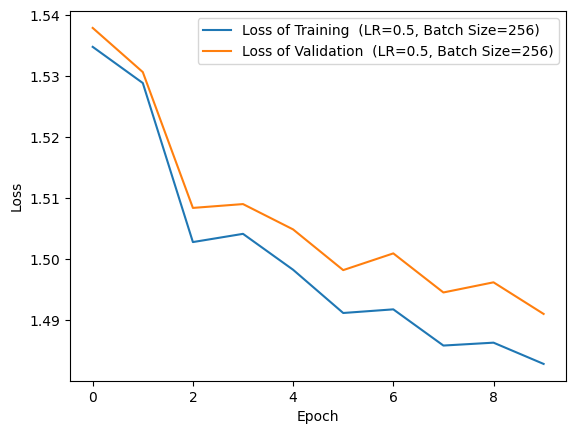

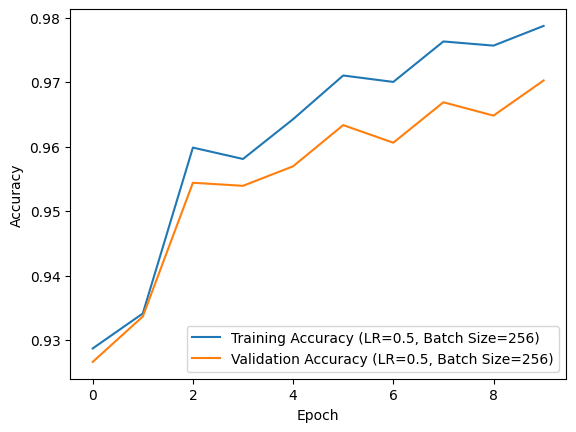


Training with Learning Rate: 0.5, Batch Size: 512
Epoch number: 1/10, Training Loss is: 1.5564, Training Accuracy is: 0.9120, Validation Loss is: 1.5609, Validation Accuracy is: 0.9072
Epoch number: 2/10, Training Loss is: 1.5191, Training Accuracy is: 0.9454, Validation Loss is: 1.5248, Validation Accuracy is: 0.9390
Epoch number: 3/10, Training Loss is: 1.5130, Training Accuracy is: 0.9504, Validation Loss is: 1.5181, Validation Accuracy is: 0.9445
Epoch number: 4/10, Training Loss is: 1.5012, Training Accuracy is: 0.9619, Validation Loss is: 1.5094, Validation Accuracy is: 0.9544
Epoch number: 5/10, Training Loss is: 1.4991, Training Accuracy is: 0.9638, Validation Loss is: 1.5071, Validation Accuracy is: 0.9552
Epoch number: 6/10, Training Loss is: 1.4945, Training Accuracy is: 0.9678, Validation Loss is: 1.5024, Validation Accuracy is: 0.9596
Epoch number: 7/10, Training Loss is: 1.4889, Training Accuracy is: 0.9733, Validation Loss is: 1.4984, Validation Accuracy is: 0.9646
Epoc

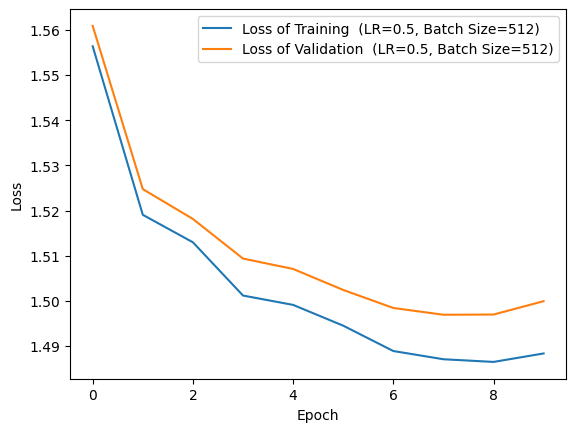

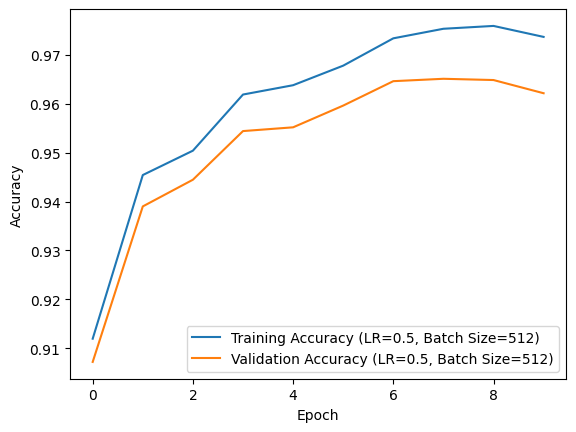


Training with Learning Rate: 1.0, Batch Size: 32
Epoch number: 1/10, Training Loss is: 1.5429, Training Accuracy is: 0.9181, Validation Loss is: 1.5448, Validation Accuracy is: 0.9166
Epoch number: 2/10, Training Loss is: 1.5303, Training Accuracy is: 0.9303, Validation Loss is: 1.5341, Validation Accuracy is: 0.9268
Epoch number: 3/10, Training Loss is: 1.5203, Training Accuracy is: 0.9409, Validation Loss is: 1.5280, Validation Accuracy is: 0.9330
Epoch number: 4/10, Training Loss is: 1.5110, Training Accuracy is: 0.9500, Validation Loss is: 1.5141, Validation Accuracy is: 0.9463
Epoch number: 5/10, Training Loss is: 1.5076, Training Accuracy is: 0.9538, Validation Loss is: 1.5118, Validation Accuracy is: 0.9491
Epoch number: 6/10, Training Loss is: 1.5005, Training Accuracy is: 0.9607, Validation Loss is: 1.5049, Validation Accuracy is: 0.9565
Epoch number: 7/10, Training Loss is: 1.5018, Training Accuracy is: 0.9592, Validation Loss is: 1.5066, Validation Accuracy is: 0.9543
Epoch

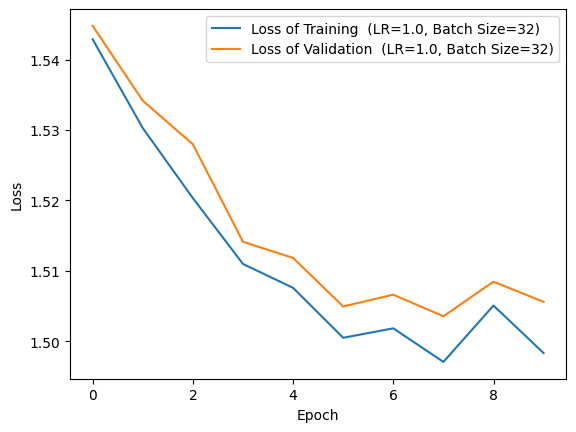

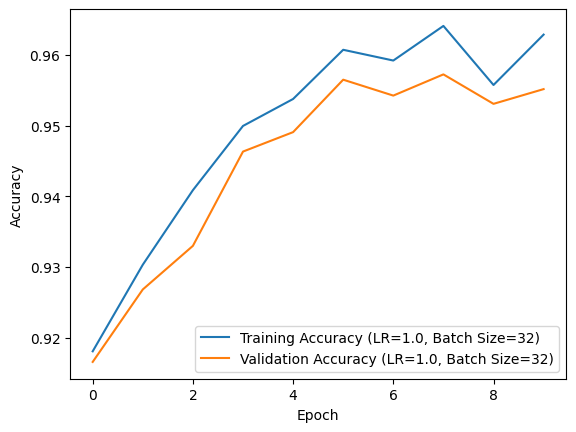


Training with Learning Rate: 1.0, Batch Size: 64
Epoch number: 1/10, Training Loss is: 1.5342, Training Accuracy is: 0.9278, Validation Loss is: 1.5356, Validation Accuracy is: 0.9262
Epoch number: 2/10, Training Loss is: 1.5130, Training Accuracy is: 0.9487, Validation Loss is: 1.5150, Validation Accuracy is: 0.9466
Epoch number: 3/10, Training Loss is: 1.5093, Training Accuracy is: 0.9523, Validation Loss is: 1.5152, Validation Accuracy is: 0.9461
Epoch number: 4/10, Training Loss is: 1.5022, Training Accuracy is: 0.9589, Validation Loss is: 1.5065, Validation Accuracy is: 0.9548
Epoch number: 5/10, Training Loss is: 1.5030, Training Accuracy is: 0.9584, Validation Loss is: 1.5083, Validation Accuracy is: 0.9533
Epoch number: 6/10, Training Loss is: 1.4951, Training Accuracy is: 0.9661, Validation Loss is: 1.5001, Validation Accuracy is: 0.9609
Epoch number: 7/10, Training Loss is: 1.4951, Training Accuracy is: 0.9661, Validation Loss is: 1.4994, Validation Accuracy is: 0.9623
Epoch

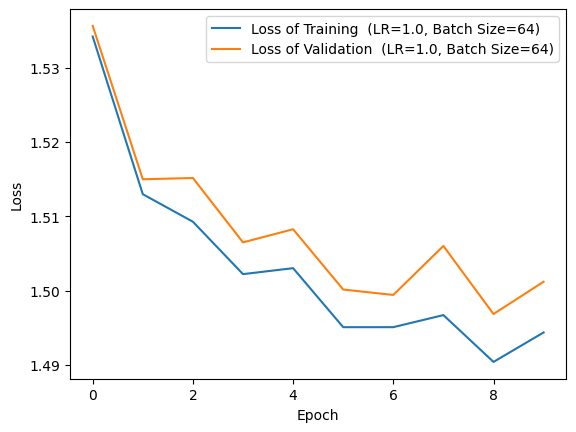

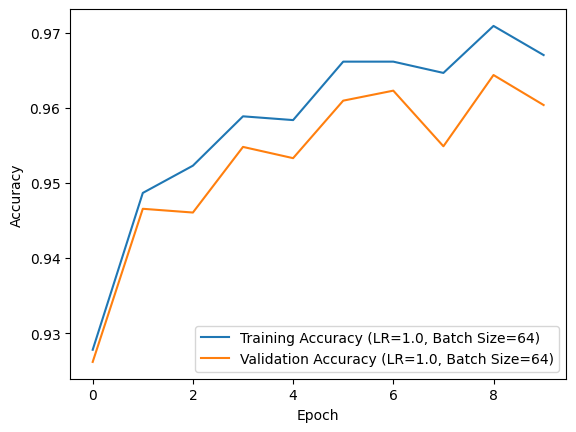


Training with Learning Rate: 1.0, Batch Size: 128
Epoch number: 1/10, Training Loss is: 1.5296, Training Accuracy is: 0.9324, Validation Loss is: 1.5338, Validation Accuracy is: 0.9281
Epoch number: 2/10, Training Loss is: 1.5249, Training Accuracy is: 0.9373, Validation Loss is: 1.5311, Validation Accuracy is: 0.9313
Epoch number: 3/10, Training Loss is: 1.5280, Training Accuracy is: 0.9345, Validation Loss is: 1.5365, Validation Accuracy is: 0.9252
Epoch number: 4/10, Training Loss is: 1.4984, Training Accuracy is: 0.9630, Validation Loss is: 1.5029, Validation Accuracy is: 0.9582
Epoch number: 5/10, Training Loss is: 1.4976, Training Accuracy is: 0.9639, Validation Loss is: 1.5056, Validation Accuracy is: 0.9557
Epoch number: 6/10, Training Loss is: 1.4918, Training Accuracy is: 0.9697, Validation Loss is: 1.4980, Validation Accuracy is: 0.9639
Epoch number: 7/10, Training Loss is: 1.4925, Training Accuracy is: 0.9689, Validation Loss is: 1.5002, Validation Accuracy is: 0.9609
Epoc

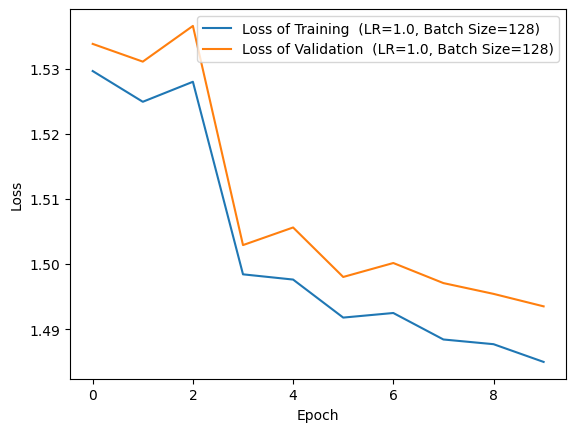

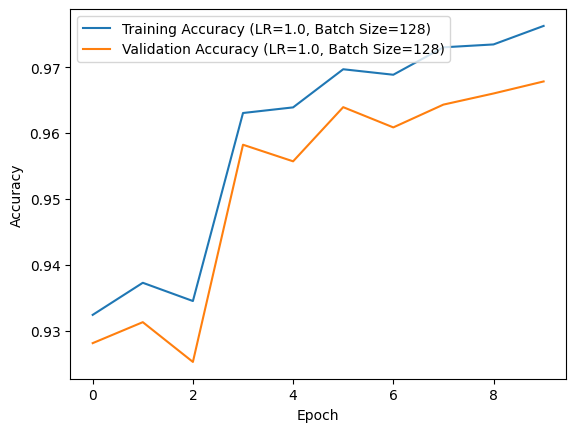


Training with Learning Rate: 1.0, Batch Size: 256
Epoch number: 1/10, Training Loss is: 1.5723, Training Accuracy is: 0.8907, Validation Loss is: 1.5756, Validation Accuracy is: 0.8859
Epoch number: 2/10, Training Loss is: 1.5164, Training Accuracy is: 0.9462, Validation Loss is: 1.5205, Validation Accuracy is: 0.9412
Epoch number: 3/10, Training Loss is: 1.5174, Training Accuracy is: 0.9446, Validation Loss is: 1.5238, Validation Accuracy is: 0.9370
Epoch number: 4/10, Training Loss is: 1.5125, Training Accuracy is: 0.9496, Validation Loss is: 1.5163, Validation Accuracy is: 0.9456
Epoch number: 5/10, Training Loss is: 1.5018, Training Accuracy is: 0.9601, Validation Loss is: 1.5076, Validation Accuracy is: 0.9538
Epoch number: 6/10, Training Loss is: 1.4947, Training Accuracy is: 0.9668, Validation Loss is: 1.5015, Validation Accuracy is: 0.9601
Epoch number: 7/10, Training Loss is: 1.4917, Training Accuracy is: 0.9697, Validation Loss is: 1.4998, Validation Accuracy is: 0.9620
Epoc

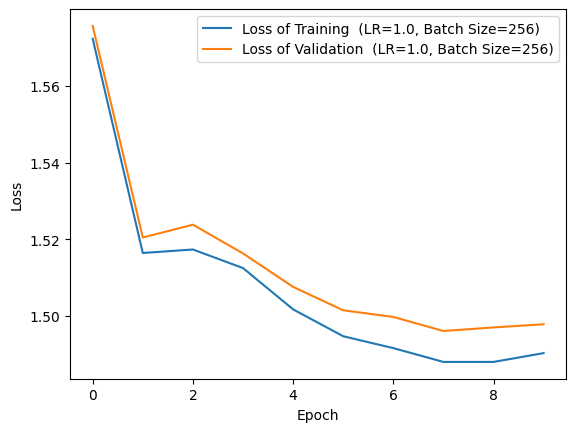

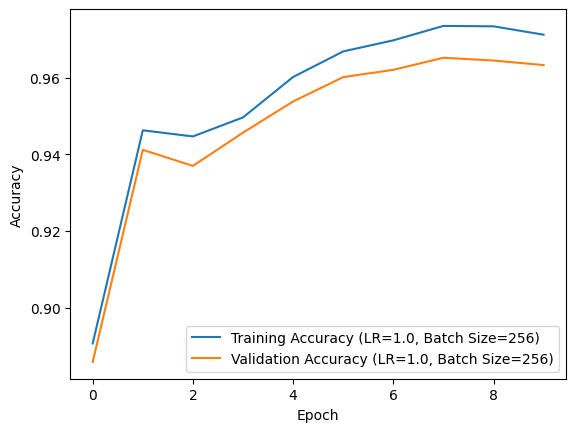


Training with Learning Rate: 1.0, Batch Size: 512
Epoch number: 1/10, Training Loss is: 1.5621, Training Accuracy is: 0.9028, Validation Loss is: 1.5636, Validation Accuracy is: 0.9013
Epoch number: 2/10, Training Loss is: 1.5262, Training Accuracy is: 0.9371, Validation Loss is: 1.5293, Validation Accuracy is: 0.9337
Epoch number: 3/10, Training Loss is: 1.5118, Training Accuracy is: 0.9503, Validation Loss is: 1.5169, Validation Accuracy is: 0.9456
Epoch number: 4/10, Training Loss is: 1.5048, Training Accuracy is: 0.9575, Validation Loss is: 1.5121, Validation Accuracy is: 0.9505
Epoch number: 5/10, Training Loss is: 1.5003, Training Accuracy is: 0.9619, Validation Loss is: 1.5068, Validation Accuracy is: 0.9548
Epoch number: 6/10, Training Loss is: 1.4945, Training Accuracy is: 0.9674, Validation Loss is: 1.5015, Validation Accuracy is: 0.9603
Epoch number: 7/10, Training Loss is: 1.4905, Training Accuracy is: 0.9714, Validation Loss is: 1.4993, Validation Accuracy is: 0.9616
Epoc

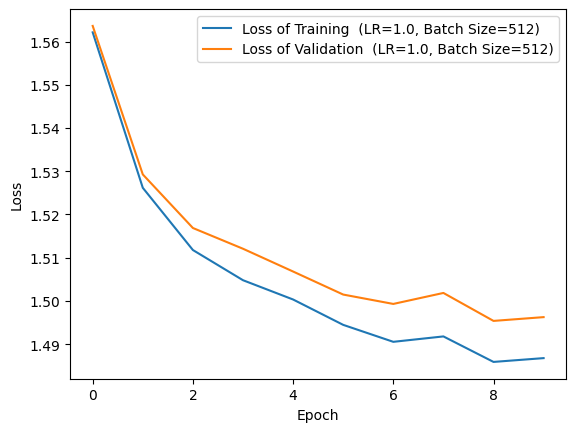

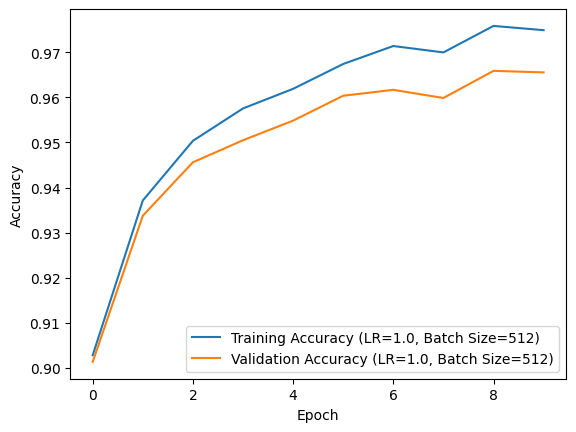

In [26]:
alphas = [0.001, 0.01, 0.1, 0.5, 1.0]
batchs_size = [32, 64, 128, 256, 512]
models = {}

for lr in alphas:
    for batch_size in batchs_size:
        print(f"\nTraining with Learning Rate: {lr}, Batch Size: {batch_size}")
        models[(batch_size, lr)] = training_loop(lr, batch_size)

Select the best model based on validation performance

In [27]:
least_loss = math.inf
best_model_of_models = None
best_paramters = None

for tuple1, tuple2 in models.items():
    model, loss = tuple2
    if loss < least_loss:
        best_paramters = tuple1
        least_loss = loss
        best_model_of_models = model

Evaluate the best model on the test set

In [28]:
test_loader = torch.utils.data.DataLoader(dataset=mnist_test_data, batch_size=best_paramters[0], shuffle=False)

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
model=best_model_of_models

test_loader.dataset.transform = transform

loss_function = nn.CrossEntropyLoss()

test_set_loss = sum(loss_function(model(inputs), labels) for inputs, labels in test_loader)
test_set_loss /= len(test_loader)

test_set_accuracy = sum((model(inputs).argmax(dim=1) == labels).float().mean().item() for inputs, labels in test_loader)
test_set_accuracy /= len(test_loader)
print(f"best parameters so far batch size = {best_paramters[0]} learning rate = {best_paramters[1]}")
print(f"Test loss of best model is {test_set_loss: .4} Test accuracy of best model is {test_set_accuracy: .4}")

best parameters so far batch size = 128 learning rate = 0.5
Test loss of best model is  1.719 Test accuracy of best model is  0.7437
